In [1]:
from PIL import Image
import numpy as np
import pandas as pd
import string, nltk, os
from time import sleep
from tqdm.auto import tqdm

%matplotlib inline
import matplotlib.pyplot as plt
from nltk.corpus import stopwords

import torch
import torch.nn as nn
import torch.nn.functional as F
from torchtext.vocab import GloVe
from collections import OrderedDict
from torchtext.data import get_tokenizer
from torchvision import models, transforms
from torch.utils.data import Dataset, DataLoader

In [2]:
base_path = 'pvqa/'

pvqa_dic_path = base_path + 'pvqa_dictionary.pkl'
test_img_id2idx_path = base_path + 'test_img_id2idx.pkl'
train_img_id2idx_path = base_path + 'train_img_id2idx.pkl'
val_img_id2idx_path = base_path + 'val_img_id2idx.pkl'

pvqa_dic_pkl = pd.read_pickle(pvqa_dic_path)
test_img_id2idx_pkl = pd.read_pickle(test_img_id2idx_path)
train_img_id2idx_pkl = pd.read_pickle(train_img_id2idx_path)
val_img_id2idx_pkl = pd.read_pickle(val_img_id2idx_path)

In [3]:
qas_base_path = base_path + 'qas/'

q2a_path = qas_base_path + 'q2a.pkl'
ans2lbl_path = qas_base_path + 'ans2label.pkl'
qid2a_path = qas_base_path + 'qid2a.pkl'
qid2q_path = qas_base_path + 'qid2q.pkl'
test_vqa_path = qas_base_path + 'test_vqa.pkl'
train_vqa_path = qas_base_path + 'train_vqa.pkl'
val_vqa_path = qas_base_path + 'val_vqa.pkl'
train_qa_path = qas_base_path + 'train/train_qa.pkl'
trainval_ans2lbl_path = qas_base_path + 'trainval_ans2label.pkl'
trainval_lbl2ans_path = qas_base_path + 'trainval_label2ans.pkl'

q2a_pairs = pd.read_pickle(q2a_path)
ans2lbl_pairs = pd.read_pickle(ans2lbl_path)
qid2a_pairs = pd.read_pickle(qid2a_path)
qid2q_pairs = pd.read_pickle(qid2q_path)
test_vqa_pairs = pd.read_pickle(test_vqa_path)
train_vqa_pairs = pd.read_pickle(train_vqa_path)
train_qa_pairs = pd.read_pickle(train_qa_path)
val_vqa_pairs = pd.read_pickle(val_vqa_path)
trainval_lbl2ans_pairs = pd.read_pickle(trainval_lbl2ans_path)
trainval_ans2lbl_pairs = pd.read_pickle(trainval_ans2lbl_path)

In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

RESIZE = 448
BATCH_SIZE = 100
MAX_LEN = 37
ans2lbl_len = 4092

In [5]:
train_vqa_df = pd.DataFrame(train_vqa_pairs)
val_vqa_df = pd.DataFrame(val_vqa_pairs)
test_vqa_df = pd.DataFrame(test_vqa_pairs)

In [6]:
test_vqa_df

,answer_type,img_id,label,question_id,question_type,sent
0,other,test_0167,{'the histone subunits': 1},300167000,what,"What are positively charged, thus allowing th..."
1,other,test_0167,{'positively charged': 1},300167001,how,How are the histone subunits charged?
2,yes/no,test_0167,{'yes': 1},300167002,are,"Are the histone subunits positively charged, ..."
3,other,test_0099,{'the principal cellular alterations that char...,300099000,what,What are illustrated?
4,yes/no,test_0099,{'yes': 1},300099001,are,Are the principal cellular alterations that ch...
...,...,...,...,...,...,...
6756,other,test_0648,{'kidney': 1},300648002,what,What is present?
6757,yes/no,test_0648,{'yes': 1},300648003,is,Is kidney present?
6758,other,test_0648,{'sarcoidosis': 1},300648004,what,What is present?
6759,yes/no,test_0648,{'yes': 1},300648005,is,Is sarcoidosis present?


In [7]:
train_vqa_df

,answer_type,img_id,label,question_id,question_type,sent
0,other,train_0422,{'in the canals of hering': 1},100422000,where,Where are liver stem cells (oval cells) located?
1,other,train_0422,{'bile duct cells and canals of hering': 1},100422001,what,What are stained here with an immunohistochemi...
2,other,train_0422,{'an immunohistochemical stain': 1},100422002,what,What are bile duct cells and canals of Hering ...
3,yes/no,train_0422,{'yes': 1},100422003,are,Are bile duct cells and canals of Hering stain...
4,other,train_0986,{'an infarct in the brain': 1},100986000,what,What shows dissolution of the tissue?
...,...,...,...,...,...,...
19750,other,train_2794,{'urinary': 1},102794003,where,Where is this?
19751,other,train_2584,{'polyarteritis nodosa': 1},102584000,what,What does this image show?
19752,yes/no,train_2584,{'yes': 1},102584001,does,"Does this image show polyarteritis nodosa, kid..."
19753,yes/no,train_2584,{'no': 1},102584002,does,"Does cytomegaly show polyarteritis nodosa, kid..."


In [8]:
val_vqa_df

,answer_type,img_id,label,question_id,question_type,sent
0,other,val_0261,{'neutrophils': 1},200261000,what,What have lost their nuclei?
1,other,val_0261,{'neutrophils': 1},200261001,whose,Whose nuclei have been lost?
2,other,val_0261,{'their': 1},200261002,two,Two have lost whose nuclei ?
3,other,val_0178,{'the embolus': 1},200178000,what,What is composed of hematopoietic marrow and m...
4,other,val_0178,{'hematopoietic marrow and marrow fat cells': 1},200178001,what,What is the embolus composed of?
...,...,...,...,...,...,...
6274,other,val_0919,{'urinary': 1},200919005,where,Where is this?
6275,other,val_0849,{'polyarteritis nodosa': 1},200849000,what,What does this image show?
6276,yes/no,val_0849,{'yes': 1},200849001,does,"Does this image show polyarteritis nodosa, kid..."
6277,yes/no,val_0849,{'no': 1},200849002,does,Does metastatic carcinoma lung show polyarteri...


In [9]:
tr_q = list(train_vqa_df['sent'])
val_q = list(val_vqa_df['sent'])
ts_q = list(test_vqa_df['sent'])

tr_a = [q2a_pairs[each] for each in tr_q]
val_a = [q2a_pairs[each] for each in val_q]
ts_a = [q2a_pairs[each] for each in ts_q]

qs = [tr_q, val_q, ts_q]
ans = [tr_a, val_a, ts_a]

del tr_q, tr_a, ts_q, ts_a, val_q, val_a

In [10]:
print(len(set(ans[0])))
print(len(set(ans[1])))
print(len(set(ans[2])))

1935
681
737


In [11]:
nltk.download('stopwords')
sw_nltk = stopwords.words('english')
tokenizer = get_tokenizer("basic_english")

# for each in qs:
#     for i in range(len(each)):
#         tmp = each[i].lower()
#         tmp = tokenizer(tmp)
#         each[i] = [token for token in tmp if token not in string.punctuation]

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\moham\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [12]:
val_lens = [len(each) for each in qs[1]]
tr_lens = [len(each) for each in qs[0]]
ts_lens = [len(each) for each in qs[2]]

print('Question with maximum length in validation set:', max(val_lens))
print('Question with minimum length in validation set:', min(val_lens))
print('Question with maximum length in training set:', max(tr_lens))
print('Question with minimum length in training set:', min(tr_lens))
print('Question with maximum length in test set:', max(ts_lens))
print('Question with minimum length in test set:', min(ts_lens))

del tr_lens, val_lens, ts_lens


Question with maximum length in validation set: 252
Question with minimum length in validation set: 8
Question with maximum length in training set: 255
Question with minimum length in training set: 9
Question with maximum length in test set: 264
Question with minimum length in test set: 8


In [13]:
idx = 0
ans2lbl_keys = list(ans2lbl_pairs.keys())

for each in ans:
	for i in range(len(each)):
		if each[i] not in ans2lbl_keys:
			ans2lbl_pairs[each[i]] = ans2lbl_len + idx
			idx += 1

del ans2lbl_keys

In [14]:
num_classes = len(list(ans2lbl_pairs.keys()))
print(num_classes)
anss = list(ans2lbl_pairs.keys())
lbls = list(range(0, len(anss)))
ans2lbl_pairs = dict(zip(anss, lbls))

del anss, lbls

4645


In [15]:
dfs = [train_vqa_df, val_vqa_df, test_vqa_df]

del train_vqa_df, val_vqa_df, test_vqa_df

for i in range(len(dfs)):
    dfs[i]['question'] = dfs[i]['sent']
    dfs[i]['answer'] = pd.Series(ans[i])
    dfs[i]['label'] = pd.Series([ans2lbl_pairs[each] for each in ans[i]])

    if i == 0:
        dfs[i]['img_id'] = base_path + 'images/train/' + dfs[i]['img_id']
    elif i == 1:
        dfs[i]['img_id'] = base_path + 'images/val/' + dfs[i]['img_id']
    else:
        dfs[i]['img_id'] = base_path + 'images/test/' + dfs[i]['img_id']

    dfs[i].drop(['sent', 'answer_type', 'question_id', 'question_type'], axis=1, inplace=True)

In [16]:
dfs[0].head()

,img_id,label,question,answer
0,pvqa/images/train/train_0422,0,Where are liver stem cells (oval cells) located?,in the canals of hering
1,pvqa/images/train/train_0422,1,What are stained here with an immunohistochemi...,bile duct cells and canals of hering
2,pvqa/images/train/train_0422,2,What are bile duct cells and canals of Hering ...,an immunohistochemical stain
3,pvqa/images/train/train_0422,3,Are bile duct cells and canals of Hering stain...,yes
4,pvqa/images/train/train_0986,4,What shows dissolution of the tissue?,an infarct in the brain


In [17]:
dfs[1].head()

,img_id,label,question,answer
0,pvqa/images/val/val_0261,1282,What have lost their nuclei?,neutrophils
1,pvqa/images/val/val_0261,1282,Whose nuclei have been lost?,neutrophils
2,pvqa/images/val/val_0261,36,Two have lost whose nuclei ?,their
3,pvqa/images/val/val_0178,3273,What is composed of hematopoietic marrow and m...,the embolus
4,pvqa/images/val/val_0178,3274,What is the embolus composed of?,hematopoietic marrow and marrow fat cells


In [18]:
dfs[2].head()

,img_id,label,question,answer
0,pvqa/images/test/test_0167,4135,"What are positively charged, thus allowing th...",the histone subunits
1,pvqa/images/test/test_0167,4136,How are the histone subunits charged?,positively charged
2,pvqa/images/test/test_0167,3,"Are the histone subunits positively charged, ...",yes
3,pvqa/images/test/test_0099,4137,What are illustrated?,the cellular alterations in apoptosis are illu...
4,pvqa/images/test/test_0099,3,Are the principal cellular alterations that ch...,yes


In [19]:
word2ids = pvqa_dic_pkl[0]
keys = ['<oov>'] + list(word2ids.keys())
vals = list(word2ids.values())
vals = [1] + [each + 2 for each in vals]
word2ids = dict(zip(keys, vals))

del keys, vals


In [20]:
EMBEDDING_DIM = 50

glove= GloVe(name='6B', dim=EMBEDDING_DIM)
emb = torch.nn.Embedding.from_pretrained(glove.vectors, freeze=True)

In [21]:
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

data_transforms = {
    'train':
    transforms.Compose([
        transforms.Resize((RESIZE, RESIZE)),
        # transforms.RandomAffine(0, shear=10, scale=(0.9,1.1)),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(10),
        # transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3, hue=0.3),
        transforms.ToTensor(),
        normalize
    ]),
    'other':
    transforms.Compose([
        transforms.Resize((RESIZE, RESIZE)),
        transforms.ToTensor(),
        normalize
    ]),
}

In [22]:
def text_preprocess(text, tokenizer, embedder, vocab, max_len):

    text = text.lower()
    tokens = tokenizer(text)
    tokens = [token for token in tokens if token not in string.punctuation]
    ids = []

    for i in range(len(tokens)):
        if tokens[i] not in list(vocab.keys()):
            ids.append(vocab['<oov>'])
        else:
            ids.append(vocab[tokens[i]])


    for i in range(max_len - len(ids)):
        ids.append(0)

    text = embedder(torch.tensor(ids, dtype=torch.long))
    text = torch.mean(text, dim=0)

    return text

In [23]:
class VQADataset(Dataset):
    def __init__(self,
                df,
                tokenizer,
                embedder,
                vocab,
                max_len,
                img_transform=None,
                txt_transform=None,
                shuffle_data=True):

        self.df = df
        self.tokenizer = tokenizer
        self.emb = embedder
        self.vocab = vocab
        self.max_len = max_len

        if shuffle_data:
            self.df = self.df.sample(frac=1).reset_index(drop=True)
        self.vocab = vocab

        self.img_transform = img_transform
        self.txt_transform = txt_transform


    def __len__(self) -> int:
        return len(self.df)

    def __getitem__(self, idx) -> tuple:
        image = Image.open(self.df.iloc[idx, 0] + '.jpg').convert("RGB")
        question = self.df.iloc[idx, 2]
        label = self.df.iloc[idx, 1]

        if self.img_transform:
            image = self.img_transform(image)
        if self.txt_transform:
            question = self.txt_transform(question,
                                        self.tokenizer,
                                        self.emb,
                                        self.vocab,
                                        self.max_len)


        return image, question, label

In [24]:
tr_dt = VQADataset(dfs[0],
                tokenizer,
                emb,
                word2ids,
                MAX_LEN,
                data_transforms['train'],
                text_preprocess)

val_dt = VQADataset(dfs[1],
                tokenizer,
                emb,
                word2ids,
                MAX_LEN,
                data_transforms['other'],
                text_preprocess)

ts_dt = VQADataset(dfs[2],
                tokenizer,
                emb,
                word2ids,
                MAX_LEN,
                data_transforms['other'],
                text_preprocess)


tr_loader = DataLoader(tr_dt, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dt, batch_size=BATCH_SIZE, shuffle=True)
ts_loader = DataLoader(ts_dt, batch_size=BATCH_SIZE, shuffle=True)

dataloaders = {'train': tr_loader, 'validation': val_loader, 'test': ts_loader}

del tr_loader, ts_loader, val_loader

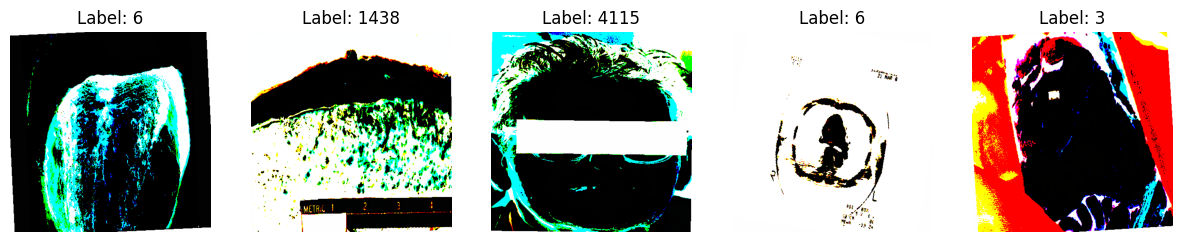

In [25]:
num_samples = 5
random_indices = np.random.randint(0, len(tr_dt), num_samples)

# Plot the images
fig, axes = plt.subplots(1, num_samples, figsize=(15, 3))

for i, idx in enumerate(random_indices):
    image, question, label = tr_dt[idx]
    image = image.permute(1, 2, 0)
    axes[i].imshow(np.uint8(np.array(image)))
    axes[i].set_title(f"Label: {label}")
    axes[i].axis('off')

plt.show()

In [26]:
class AttentionLayer(nn.Module):
    def __init__(self, dim):
        super().__init__()

        self.representation_dim = dim
        self.fi_lin = nn.Sequential(
            nn.Linear(self.representation_dim, self.representation_dim, bias=True),
            nn.Linear(self.representation_dim, self.representation_dim, bias=True)
        )
        self.vi_lin = nn.Linear(self.representation_dim, self.representation_dim, bias=False)
        self.vq_lin = nn.Linear(self.representation_dim, self.representation_dim, bias=True)
        self.pi_lin = nn.Linear(self.representation_dim, 1, bias=True)


    def forward(self, fi, vq):

        # print('fi\'s shape:', fi.shape)
        fi = fi.view((fi.shape[0], -1, fi.shape[1]))
        vi = F.tanh(self.fi_lin(fi))
        # print('vi\'s shape:', vi.shape)
        vi2 = self.vi_lin(vi)
        # print('vi2\'s shape:', vi2.shape)
        vq2 = self.vq_lin(vq)
        vq2 = vq2.view((vq2.shape[0], 1, vq2.shape[1]))
        # print('vq2\'s shape:', vq2.shape)
        ha = F.tanh(vi2 + vq2)
        # print('ha\'s shape:', ha.shape)
        pi = F.softmax(self.pi_lin(ha), dim=1)
        # print('pi\'s shape:', pi.shape)
        v = torch.sum((pi * vi2), dim=1)
        # print('v\'s shape:', v.shape)
        u = v + vq
        # print('u\'s shape:', u.shape)
        return u

In [27]:
class VQAModel(nn.Module):
    def __init__(self,
                input_representation_shape: int,
                txt_embedd_dim: int,
                num_classes: int,
                num_lstm_layers: int=2,
                ) -> None:
        super().__init__()

        self.txt_encoder = nn.LSTM(txt_embedd_dim, input_representation_shape, num_lstm_layers, batch_first=True)

        self.img_encoder = models.resnet18(weights='DEFAULT')
        self.img_encoder = torch.nn.Sequential(OrderedDict([*(list(self.img_encoder.named_children())[:-2])]))
        for param in self.img_encoder.parameters():
            param.requires_grad = False

        self.att1 = AttentionLayer(input_representation_shape)
        self.att2 = AttentionLayer(input_representation_shape)
        self.fc = nn.Linear(input_representation_shape, num_classes)


    def forward(self, vi: torch.Tensor, vq: torch.Tensor) -> torch.Tensor:
        q = self.txt_encoder(vq)[0]
        i = self.img_encoder(vi)
        u = self.att1(i, q)
        u = self.att2(i, u)
        u = F.softmax(self.fc(u), dim=1)
        return u

In [28]:
def train_model(model, criterion, optimizer, num_epochs=3):
    for epoch in range(num_epochs):
        print('-' * 50)
        print('Epoch {}/{}'.format(epoch+1, num_epochs))
        print('-' * 10)

        for phase in ['train', 'validation']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0

            with tqdm(dataloaders[phase], unit='batch', position=0, leave=True) as pbar:
                for img, txt, lbl in pbar:

                    pbar.set_description(f"Epoch {epoch+1}")

                    img = img.to(device)
                    txt = txt.to(device)
                    lbl = lbl.to(device)
                    # print(labels)
                    outputs = model(img,  txt)
                    # print('--' * 35)
                    # print('model output shape:', outputs.shape)
                    # lbl_oh = F.one_hot(lbl, num_classes=num_classes).float()
                    # print('labels shape:', lbl.shape)
                    loss = criterion(outputs, F.one_hot(lbl, num_classes=num_classes).float())

                    if phase == 'train':
                        optimizer.zero_grad()
                        loss.backward()
                        optimizer.step()

                    _, preds = (torch.max(outputs, 1))
                    # preds = F.one_hot(preds, num_classes=num_classes).float()
                    # print('--' * 35)
                    # print('prediction shape:', preds.shape)
                    running_loss += loss.item()
                    running_corrects += torch.sum(preds == lbl.data)
                    # print('acc:', running_corrects)
                    # print()
                    pbar.set_postfix(loss=running_loss, accuracy=running_corrects.item())
                    sleep(0.1)

            epoch_loss = running_loss / len(dataloaders[phase])
            epoch_acc = running_corrects.double() / len(dataloaders[phase])

            print('{} loss: {:.4f}, acc: {:.4f}'.format(phase,
                                                        epoch_loss,
                                                        epoch_acc))
    return model

In [29]:
torch.manual_seed(42)
model = VQAModel(input_representation_shape=512, txt_embedd_dim=EMBEDDING_DIM, num_classes=num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=model.parameters(), lr=0.1, momentum=0.9)

model_trained = train_model(model, criterion, optimizer, num_epochs=1)

--------------------------------------------------
Epoch 1/5
----------


  0%|          | 0/198 [00:00<?, ?batch/s]

train loss: 8.4433, acc: 18.3535


  0%|          | 0/63 [00:00<?, ?batch/s]

validation loss: 8.4391, acc: 25.6984
--------------------------------------------------
Epoch 2/5
----------


  0%|          | 0/198 [00:00<?, ?batch/s]

train loss: 8.1938, acc: 25.5101


  0%|          | 0/63 [00:00<?, ?batch/s]

validation loss: 8.1860, acc: 25.6984
--------------------------------------------------
Epoch 3/5
----------


  0%|          | 0/198 [00:00<?, ?batch/s]

train loss: 8.1884, acc: 25.5101


  0%|          | 0/63 [00:00<?, ?batch/s]

validation loss: 8.1862, acc: 25.6984
--------------------------------------------------
Epoch 4/5
----------


  0%|          | 0/198 [00:00<?, ?batch/s]

train loss: 8.1883, acc: 25.5101


  0%|          | 0/63 [00:00<?, ?batch/s]

validation loss: 8.1859, acc: 25.6984
--------------------------------------------------
Epoch 5/5
----------


  0%|          | 0/198 [00:00<?, ?batch/s]

train loss: 8.1882, acc: 25.5101


  0%|          | 0/63 [00:00<?, ?batch/s]

validation loss: 8.1863, acc: 25.6984


In [40]:
from sklearn.metrics import f1_score


model_trained.eval()
f1 = []

with tqdm(dataloaders['test'], unit='batch', position=0, leave=True) as pbar:
    for X, y, z in pbar: 
        X = X.to(device)
        y = y.to(device)
        z = z.to(device)
        outputs = model(X, y)
        _, preds = (torch.max(outputs, 1))
        f1.append(f1_score(np.array(z.cpu()), np.array(preds.cpu()), average='micro'))

f1 = np.mean(np.array(f1))
print(f1)

  0%|          | 0/68 [00:00<?, ?batch/s]

0.2737512054001929
